# Course Overview and Moving Averages

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

### Course goals

- Get exposure to quantitative investment strategies
- Learn the types of risk adjustments people do to analyze all investment strategies - information ratios, attribution analysis, ...
- Learn to **execute** python code to backtest and analyze strategies

I am not promising you will be proficient at **writing** python code by the end of the course, but ChatGPT can help.

### Course materials

- Slides, assignments, and links to notebooks at mgmt638.kerryback.com
- Submit assignments on Canvas
- Three versions of slides: html, pdf, and Jupyter notebook
- The notebook is more inclusive.  It contains all of the code to do all of the analysis that is presented in the html and pdf slides.
- Notebooks are set to open on Google Colab.

### Grading

- Grades will be based on individual weekly assignments (80%) and class participation (20%).
- We will do work similar to the assignments in class each week, so there will be an opportunity for coaching.

### Data

- We have data in a SQL database on a JGSB server.  The data is provided by Nasdaq Data Link.
- It is behind the Rice firewall.  You must be on the Rice network (RiceOwls not RiceVisitor) or on the Rice VPN.  It is also password protected.
- We cannot access the data while running on Google Colab, because Colab is not behind the firewall.
- We will not use this data during the first week of class.

### Backtesting 

- Idea + data $\rightarrow$ backtest
- Can we reasonably backtest the strategy "buy electric car companies whose name starts with T?"
- We can backtest a more general strategy with two parameters: type of company, first letter of name
- We can backtest in a loop, updating once per year for example:
  - Find the type of company and the first letter of name that did best in the past $n$ years
  - Buy that company and hold for a year
  - Update each year: find the new best company/first letter and hold it for a year


### Tests and other considerations

- Past average return
- Sharpe ratio
- CAPM alpha and information ratio
- Fama-French alpha and information ratio
- Attribution analysis
- Maximum drawdown
- Tracking error relative to a benchmark
- Correlation with other strategies
- Turnover and ransactions costs (including shorting fees)

### Universe of stocks

- Large cap or small cap or mid cap or some of all?
- Industries: do we want to bet on industries or match industry weights to a benchmark?
- Value vs growth, etc.
- Our goal could be to find the best possible strategy without any constraints or we might be constrained to find the best strategy within mid-cap energy, for example.
- Different strategies may work better or worse depending on the universe of stocks we can consider.

### Example for today

- Do moving average strategies work?
- Get adjusted closing prices from Yahoo Finance 
- Adjusted for splits and dividends
- % change is total return, including dividends

In [105]:
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start="1970-01-01")["Adj Close"]
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d"))
data = pd.DataFrame(data)
data.columns = ["closeadj"]

[*********************100%***********************]  1 of 1 completed


In [106]:
data.head()

,closeadj
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


### Compute and plot moving averages

- Compute average of adjusted closing price over prior $n$ days
- Do 10 day and 50 day as illustration
- Plot from 2020 on only so we can see detail better

In [107]:
data["ten"] = data.closeadj.rolling(10).mean()
data["fifty"] = data.closeadj.rolling(50).mean()
data["ten"] = data.ten.shift()
data["fifty"] = data.fifty.shift()

import seaborn as sns 
sns.set_style("whitegrid")

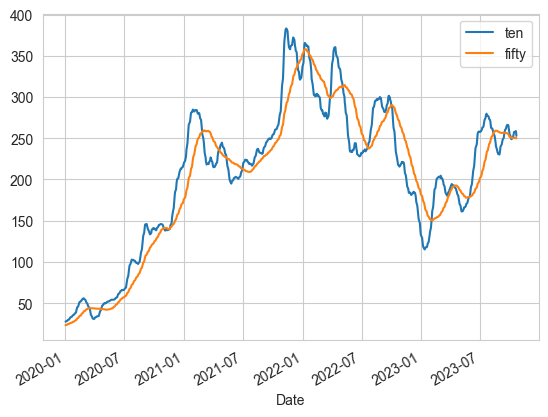

In [108]:
_ = data[["ten", "fifty"]].loc["2020-01-01":].plot()

### Compute returns

- Buy and hold return = percent change in adjusted closing price
- Moving average strategy:
  - Long all money in account when 10 day > 50 day
  - Zero position (and no interest for simplicity) otherwise

In [109]:
data["buy_hold"] = data.closeadj.pct_change()
data["long"] = data.ten > data.fifty
data["mvg_avg"] = data.buy_hold * data.long
data = data.dropna().round(3)

In [110]:
data.head()

,closeadj,ten,fifty,buy_hold,long,mvg_avg
Date,,,,,,
2010-09-09,1.381,1.351,1.322,-0.009,True,-0.009
2010-09-10,1.345,1.357,1.318,-0.026,True,-0.026
2010-09-13,1.381,1.360,1.313,0.027,True,0.027
2010-09-14,1.408,1.366,1.311,0.019,True,0.019
2010-09-15,1.465,1.375,1.314,0.041,True,0.041


### What tests do we want to do?

- Start by calculating average returns - multiply by 252 to annualize
- Then look at plot of compound returns - log scale works better for long time period
- Compute Sharpe ratios
- CAPM alphas, ...

### Mean returns

In [88]:
buy_hold = 252*data.buy_hold.mean() 
mvg_avg = 252*data.mvg_avg.mean()

print(f"buy and hold mean return is {buy_hold:.2%} annualized")
print(f"moving average mean return is {mvg_avg:.2%} annualized")

buy and hold mean return is 54.73% annualized
moving average mean return is 37.75% annualized


### Compound return plots

- We will plot the compound return (how much your money grows to starting from $1).
- First in a normal scale and then in a log scale.

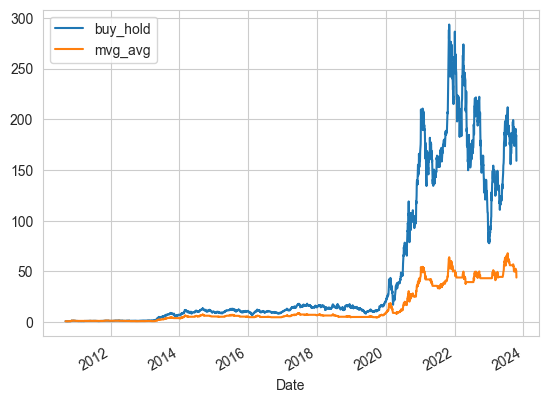

In [89]:
_ = (1+data[["buy_hold", "mvg_avg"]]).cumprod().plot()

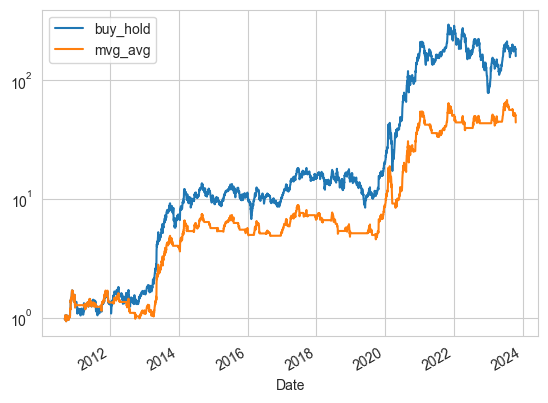

In [90]:
_ = (1+data[["buy_hold", "mvg_avg"]]).cumprod().plot(
    logy=True
)

### Sharpe ratios

- Sharpe ratio is expected return minus risk-free rate / standard deviation
- We'll skip the risk-free rate
- Annualize mean return by multiplying by $252$
- Annualize variance by multiplying by $252$
- $\Rightarrow$ annualize standard deviation by multiplying by $\sqrt{252}$
- $\Rightarrow$ annualize Sharpe ratio by multiplying by $\sqrt{252}$

In [91]:
import numpy as np
buy_hold_sharpe = (
    np.sqrt(252) * data.buy_hold.mean() / data.buy_hold.std()
)
mvg_avg_sharpe = (
    np.sqrt(252) * data.mvg_avg.mean() / data.mvg_avg.std()
)

In [92]:
print(f"Buy and hold Sharpe ratio is {buy_hold_sharpe:.2%} annualized")
print(f"Moving average Sharpe ratio is {mvg_avg_sharpe:.2%} annualized")

Buy and hold Sharpe ratio is 96.45% annualized
Moving average Sharpe ratio is 89.47% annualized


### Multiple stocks

- We can get data for multiple stocks from Yahoo Finance by passing a list of tickers.
- Here is an example.

In [93]:
tickers = ["PG", "WMT", "CVX", "F", "MSFT"]
data = yf.download(tickers, start="2000-01-01")["Adj Close"]
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d"))
data = pd.DataFrame(data.stack())
data.columns = ["closeadj"]
data.index.names = ["date", "ticker"]

[*********************100%***********************]  5 of 5 completed


In [94]:
data.head(7)

closeadj
date       ticker           
2000-01-03 CVX     17.508463
           F       13.405162
           MSFT    36.205597
           PG      28.428761
           WMT     43.717701

- Then we can do everything we did for a single ticker by running the code in a groupby object.
- Instead of looking at returns for each stock individually, we can compare portfolios.
- We will equal weight each day for simplicity.
  - Neither of the strategies is buy and hold - we have to trade each day to get back to equal weights.
  - For the moving average strategy, we will equal weight the stocks for which the 10 day > 50 day moving average (which could be no stocks or all stocks or anything in between).

In [95]:
data["ten"] = data.groupby("ticker", group_keys=False).closeadj.apply(
    lambda x: x.rolling(10).mean()
)
data["fifty"] = data.groupby("ticker", group_keys=False).closeadj.apply(
    lambda x: x.rolling(50).mean()
)
data["ten"] = data.groupby("ticker", group_keys=False).ten.shift()
data["fifty"] = data.groupby("ticker", group_keys=False).fifty.shift()

In [96]:
data["eq_wtd"] = data.groupby("ticker", group_keys=False).closeadj.pct_change()
data["long"] = data.ten > data.fifty 
data["mvg_avg"] = data.long * data.eq_wtd
eq_wtd = data.groupby("date").eq_wtd.mean()
mvg_avg = data.groupby("date").mvg_avg.mean().fillna(0)
rets = pd.concat((eq_wtd, mvg_avg), axis=1)
rets.columns = ["eq_wtd", "mvg_avg"]

In [97]:
rets.head()

,eq_wtd,mvg_avg
date,,
2000-01-03,NaN,0.0
2000-01-04,-0.024771,0.0
2000-01-05,-0.001449,0.0
2000-01-06,0.013458,0.0
2000-01-07,0.051980,0.0


In [98]:
rets.tail()

,eq_wtd,mvg_avg
date,,
2023-10-16,0.010296,0.004630
2023-10-17,0.004664,0.002299
2023-10-18,0.000899,0.000413
2023-10-19,-0.004877,0.000946
2023-10-20,-0.001212,-0.003720


### Mean returns

In [99]:
eq_wtd = 252*rets.eq_wtd.mean() 
mvg_avg = 252*rets.mvg_avg.mean()

print(f"equally weighted mean return is {eq_wtd:.2%} annualized")
print(f"moving average mean return is {mvg_avg:.2%} annualized")


equally weighted mean return is 10.62% annualized
moving average mean return is 5.66% annualized


### Compound returns

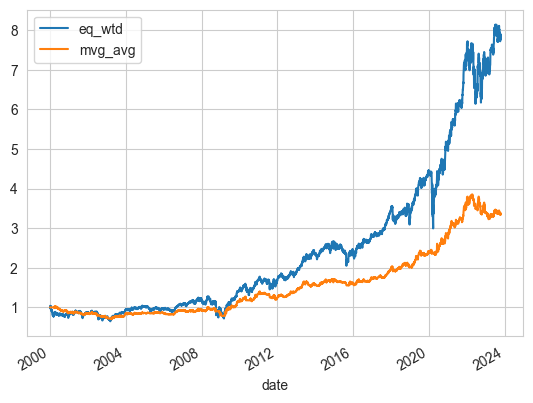

In [100]:
_ = (1+rets).cumprod().plot()

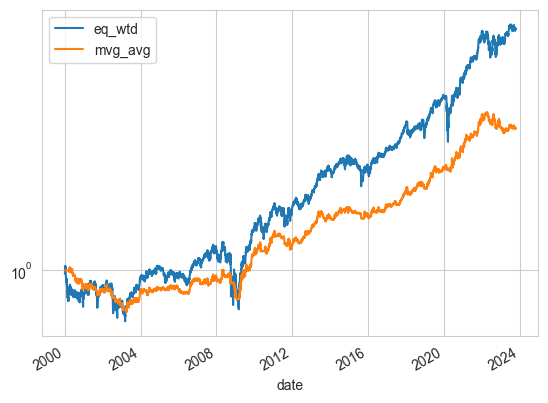

In [101]:
_ = (1+rets).cumprod().plot(logy=True)

### Sharpe ratios

In [102]:
import numpy as np
eq_wtd_sharpe = (
    np.sqrt(252) * data.eq_wtd.mean() / data.eq_wtd.std()
)
mvg_avg_sharpe = (
    np.sqrt(252) * data.mvg_avg.mean() / data.mvg_avg.std()
)

In [103]:
print(f"Equally weighted Sharpe ratio is {eq_wtd_sharpe:.2%} annualized")
print(f"Moving average Sharpe ratio is {mvg_avg_sharpe:.2%} annualized")

Equally weighted Sharpe ratio is 35.42% annualized
Moving average Sharpe ratio is 29.52% annualized


### Exercise

Look at different sets of stocks and different moving averages and test strategies.